# Diagn√≥stico Preliminar para Modelado Espacio-Temporal de PM2.5

Objetivo : preparar insumos para un modelo LUR o predictivo

**Acciones realizadas**

1. **Construcci√≥n de matriz de correlaci√≥n lineal entre variables**
    * Variables: **PM2.5, Humedad, Temperatura**
    * **Script desarrollado**:
    * C√°lculo de matriz de correlaci√≥n (`.corr()` de pandas)
    * Visualizaci√≥n con **mapa de calor (heatmap)** usando Seaborn

2. **An√°lisis de correlaci√≥n entre estaciones (PM2.5 series temporales)**
   * Evaluaci√≥n de similitud entre estaciones mediante correlaciones
   * **Script desarrollado**:
   * C√°lculo de matriz de correlaci√≥n entre estaciones
   * Visualizaci√≥n con **mapa de calor (heatmap)** para identificar patrones comunes y estaciones at√≠picas

3. **Prueba de estacionariedad (ADF - Augmented Dickey-Fuller)**
   * Aplicada a las series de PM2.5 por estaci√≥n (ejemplo: Buenos Aires)
   * **Script desarrollado**:
   * Uso de `adfuller()` de `statsmodels`
   * Reporte autom√°tico del estad√≠stico ADF, p-value y valores cr√≠ticos

6. **An√°lisis de autocorrelaci√≥n espacial (√çndice de Moran)**
   * Medici√≥n de autocorrelaci√≥n espacial de los promedios de PM2.5
   * **Script desarrollado**:
   * Uso de `esda.moran.Moran()` de la librer√≠a **PySAL**
   * Reporte de Moran‚Äôs I y p-value


Primeras 5 filas del CSV:
                       date    PM25  Humidity  Temperature  \
0 2025-03-01 01:00:00+00:00  17.745    77.936        18.17   
1 2025-03-01 02:00:00+00:00  18.760    78.760        18.00   
2 2025-03-01 03:00:00+00:00  13.200    80.000        18.00   
3 2025-03-01 04:00:00+00:00     NaN       NaN          NaN   
4 2025-03-01 05:00:00+00:00  13.000    80.000        18.00   

                     station  
0  SAM_IE_BuenosAires_306e73  
1  SAM_IE_BuenosAires_306e73  
2  SAM_IE_BuenosAires_306e73  
3  SAM_IE_BuenosAires_306e73  
4  SAM_IE_BuenosAires_306e73  

Informaci√≥n del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6902 entries, 0 to 6901
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   date         6902 non-null   datetime64[ns, UTC]
 1   PM25         5560 non-null   float64            
 2   Humidity     5560 non-null   float64            
 3   Tempe

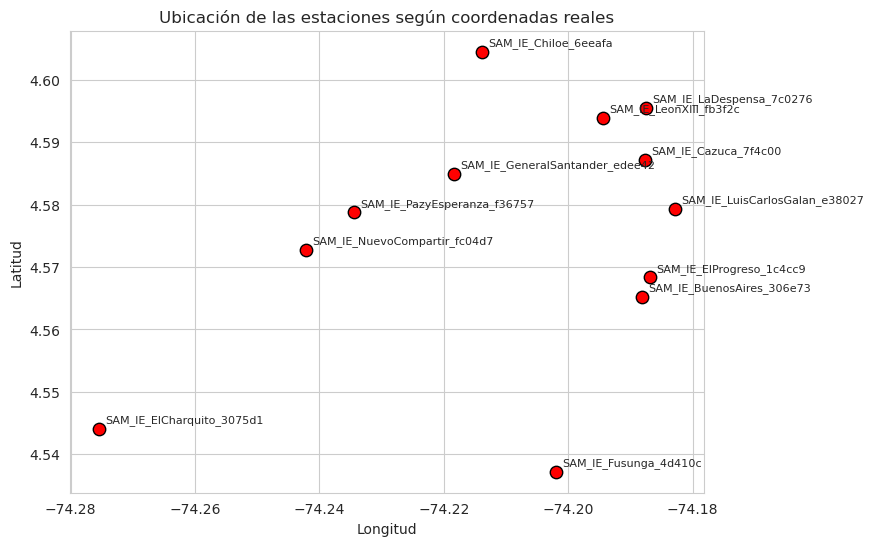


Correlaci√≥n PM2.5 vs Temperature: nan  p-value: nan
Correlaci√≥n PM2.5 vs Humidity: nan  p-value: nan

Matriz de correlaci√≥n global:
                 PM25  Humidity  Temperature
PM25         1.000000  0.178073    -0.058838
Humidity     0.178073  1.000000    -0.784590
Temperature -0.058838 -0.784590     1.000000


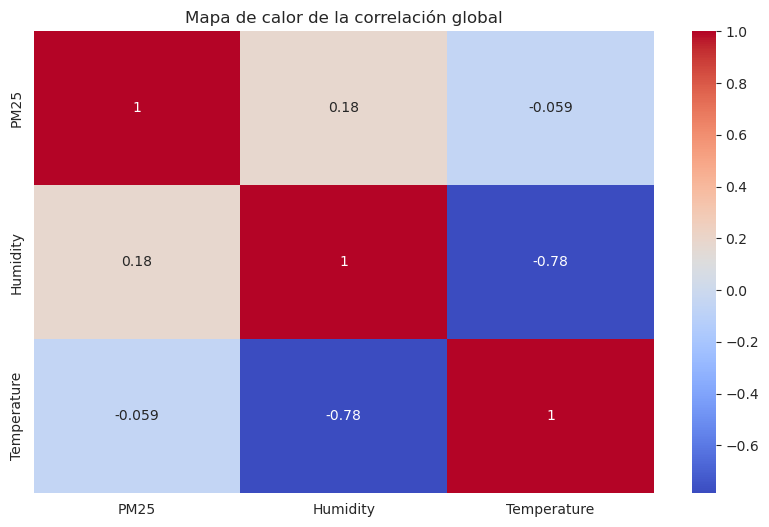

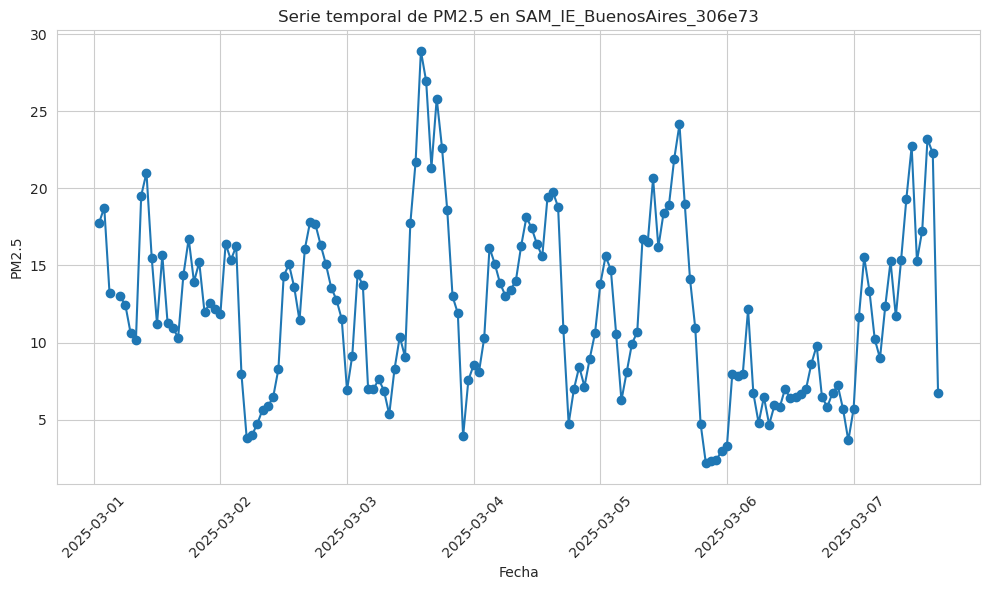


Prueba ADF para PM2.5 en SAM_IE_BuenosAires_306e73:
Estad√≠stica ADF: -4.98
p-value: 0.0

√çndice global de Moran para PM2.5 (promedio por estaci√≥n):
Moran's I = -0.214
p-value (norm.) = 0.35


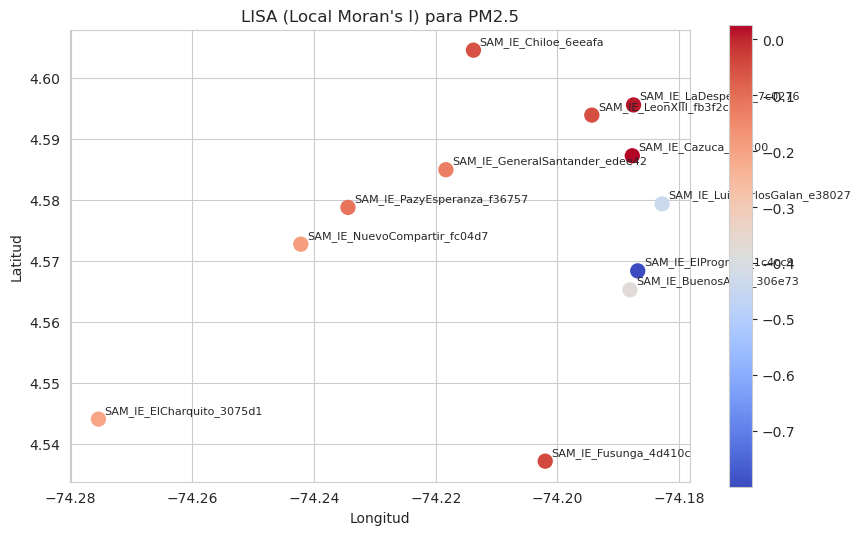


Matriz de correlaci√≥n entre series temporales de PM2.5 (por estaci√≥n):
station                         SAM_IE_BuenosAires_306e73  \
station                                                     
SAM_IE_BuenosAires_306e73                        1.000000   
SAM_IE_Cazuca_7f4c00                             0.836164   
SAM_IE_Chiloe_6eeafa                             0.751009   
SAM_IE_ElCharquito_3075d1                        1.000000   
SAM_IE_ElProgreso_1c4cc9                         0.639499   
SAM_IE_Fusunga_4d410c                            0.724556   
SAM_IE_GeneralSantander_edee42                   0.737171   
SAM_IE_LaDespensa_7c0276                         0.734764   
SAM_IE_LeonXIII_fb3f2c                           0.711042   
SAM_IE_LuisCarlosGalan_e38027                    0.809167   
SAM_IE_NuevoCompartir_fc04d7                     0.693085   
SAM_IE_PazyEsperanza_f36757                      0.701681   

station                         SAM_IE_Cazuca_7f4c00  SAM_IE_Chiloe_6ee

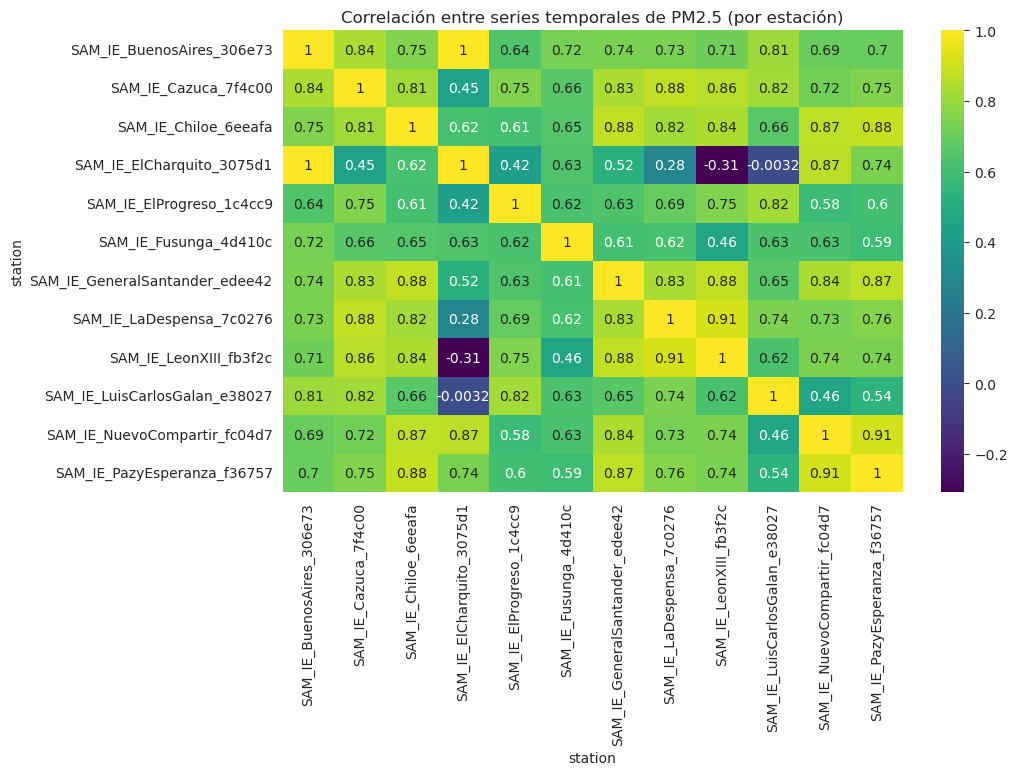

In [1]:
# IMPORTAR LIBRER√çAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Para an√°lisis temporal (prueba Dickey-Fuller)
import statsmodels.tsa.stattools as ts
from scipy.stats import pearsonr

# Para an√°lisis espacial
import geopandas as gpd
from shapely.geometry import Point
import libpysal as lp
from esda import Moran, Moran_Local

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# 1. CARGAR DATOS DEL MONITOREO (CSV)
df = pd.read_csv("data_MAR_1.csv")
df['date'] = pd.to_datetime(df['date'])
print("Primeras 5 filas del CSV:")
print(df.head())
print("\nInformaci√≥n del DataFrame:")
print(df.info())

# 2. Resumen estad√≠stico por estaci√≥n
station_summary = (
    df.groupby("station")
      .agg({
          'PM25': ['mean', 'std', 'min', 'max'],
          'Humidity': ['mean', 'std', 'min', 'max'],
          'Temperature': ['mean', 'std', 'min', 'max']
      })
).reset_index()

# Ajustamos los nombres de columna:
station_summary.columns = ["station", "PM25_mean", "PM25_std", "PM25_min", "PM25_max",
                           "Hum_mean", "Hum_std", "Hum_min", "Hum_max",
                           "Temp_mean", "Temp_std", "Temp_min", "Temp_max"]
print("\nResumen estad√≠stico por estaci√≥n:")
print(station_summary)

# 3. CARGAR LAS COORDENADAS DESDE EL ARCHIVO EXCEL
# El archivo "Coordenadas_Instituciones.xlsx" tiene la hoja "Hoja1" con columnas "Instituci√≥n" y "Coordenadas"
df_coords = pd.read_excel("Coordenadas_Instituciones.xlsx", sheet_name="Hoja1")
df_coords.rename(columns={"Estaci√≥n": "station"}, inplace=True)
print("\nDatos de coordenadas (Excel):")
print(df_coords.head())

# Las coordenadas vienen como una cadena "lat, lon". Separamos y convertimos
def split_coords(s):
    try:
        lat_str, lon_str = s.split(",")
        return float(lat_str.strip()), float(lon_str.strip())
    except:
        return (np.nan, np.nan)

# Creamos dos columnas: lat y lon
df_coords[['lat', 'lon']] = df_coords['Coordenadas'].apply(lambda x: pd.Series(split_coords(x)))
# Renombramos la columna "Instituci√≥n" para poder hacer merge
df_coords.rename(columns={"Instituci√≥n":"station"}, inplace=True)
print("\nCoordenadas separadas:")
print(df_coords[['station', 'lat', 'lon']])

# 4. Unir la informaci√≥n de coordenadas con el resumen estad√≠stico por estaci√≥n
station_summary = station_summary.merge(df_coords[['station', 'lat', 'lon']], on="station", how="left")
print("\nResumen con coordenadas reales:")
print(station_summary[['station', 'PM25_mean', 'lat', 'lon']])

# 5. Crear GeoDataFrame de las estaciones
gdf_stations = gpd.GeoDataFrame(
    station_summary,
    geometry=gpd.points_from_xy(station_summary.lon, station_summary.lat),
    crs="EPSG:4326"
)

# Mapa de las estaciones (con sus identificaciones)
ax = gdf_stations.plot(marker='o', color='red', markersize=80, edgecolor='black')
for idx, row in gdf_stations.iterrows():
    plt.text(row.geometry.x + 0.001, row.geometry.y + 0.001, row['station'], fontsize=8)
plt.title("Ubicaci√≥n de las estaciones seg√∫n coordenadas reales")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

# 6. AN√ÅLISIS DE CORRELACI√ìN GLOBAL ENTRE VARIABLES
# Correlaci√≥n global usando el dataset completo (dato a dato)
corr_pm_temp, p_val_pm_temp = pearsonr(df["PM25"], df["Temperature"])
corr_pm_hum, p_val_pm_hum = pearsonr(df["PM25"], df["Humidity"])
print("\nCorrelaci√≥n PM2.5 vs Temperature:", np.round(corr_pm_temp,3), " p-value:", np.round(p_val_pm_temp,3))
print("Correlaci√≥n PM2.5 vs Humidity:", np.round(corr_pm_hum,3), " p-value:", np.round(p_val_pm_hum,3))

# Matriz de correlaci√≥n entre PM2.5, Humidity y Temperature:
corr_matrix = df[['PM25', 'Humidity', 'Temperature']].corr()
print("\nMatriz de correlaci√≥n global:")
print(corr_matrix)
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Mapa de calor de la correlaci√≥n global")
plt.show()

# 7. AN√ÅLISIS TEMPORAL EN UNA ESTACI√ìN (ejemplo para SAM_IE_BuenosAires_306e73)
df_station = df[df["station"]=="SAM_IE_BuenosAires_306e73"].copy()
df_station = df_station.sort_values("date")
plt.plot(df_station['date'], df_station["PM25"], marker="o")
plt.title("Serie temporal de PM2.5 en SAM_IE_BuenosAires_306e73")
plt.xlabel("Fecha")
plt.ylabel("PM2.5")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# eliminar  valores faltante (tabla de datos de df_station, los valores de "PM25" no est√°n completos;
#hay m√∫ltiples registros con NaN, especialmente visibles en las primeras filas del DataFrame. 
#De hecho, seg√∫n la informaci√≥n de esa p√°gina, la columna "PM25" tiene 5563 valores no nulos de un total de 6905, 
# es decir, 1342 valores faltantes. 
# Esta l√≠nea elimina los NaN de la columna "PM25" y permite aplicar correctamente la prueba de Dickey-Fuller.
# Esta l√≠nea causa el error:
# adf_result = ts.adfuller(df_station["PM25"])

# Esta es la correcta:
adf_result = ts.adfuller(df_station["PM25"].dropna())
# Prueba de Dickey-Fuller (ADF) para evaluar la estacionariedad de la serie temporal de PM2.5

print("\nPrueba ADF para PM2.5 en SAM_IE_BuenosAires_306e73:")
print("Estad√≠stica ADF:", np.round(adf_result[0], 3))
print("p-value:", np.round(adf_result[1], 3))

# Nota: Si el p-value es menor a 0.05 se rechaza la hip√≥tesis nula de no estacionariedad.

# 8. AN√ÅLISIS ESPACIAL: √çNDICE GLOBAL DE MORAN y LISA para PM2.5
# Utilizaremos la media PM2.5 por estaci√≥n (PM25_mean) del GeoDataFrame con coordenadas reales.
# Extraemos las coordenadas en un array (en formato X, Y => lon, lat)
coords_array = station_summary[['lon', 'lat']].to_numpy()

# Construir un peso espacial con vecinos (por ejemplo, 4 vecinos)
w_knn = lp.weights.KNN.from_array(coords_array, k=4)
w_knn.transform = 'r'

# Calcular el √≠ndice global de Moran para PM25_mean
moran_global = Moran(station_summary["PM25_mean"].values, w_knn)
print("\n√çndice global de Moran para PM2.5 (promedio por estaci√≥n):")
print("Moran's I =", np.round(moran_global.I, 3))
print("p-value (norm.) =", np.round(moran_global.p_norm, 3))

# An√°lisis local (LISA): calcular Local Moran's I
local_moran = Moran_Local(station_summary["PM25_mean"].values, w_knn)
station_summary["LISA_I"] = local_moran.Is
station_summary["LISA_p"] = local_moran.p_sim



# Unir estos √≠ndices al GeoDataFrame (si a√∫n no est√° actualizado)
gdf_stations = gdf_stations.merge(station_summary[["station", "LISA_I", "LISA_p"]], on="station")
ax = gdf_stations.plot(column="LISA_I", cmap="coolwarm", legend=True, markersize=100)
for idx, row in gdf_stations.iterrows():
    plt.text(row.geometry.x+0.001, row.geometry.y+0.001, row["station"], fontsize=8)
plt.title("LISA (Local Moran's I) para PM2.5")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

# 9. AN√ÅLISIS ESPACIOTEMPORAL:
# Se arma una tabla pivote con PM2.5 (cada columna es la serie temporal de una estaci√≥n) para ver las correlaciones entre series.
df_pivot = df.pivot(index="date", columns="station", values="PM25")
print("\nMatriz de correlaci√≥n entre series temporales de PM2.5 (por estaci√≥n):")
corr_stations = df_pivot.corr()
print(corr_stations)
sns.heatmap(corr_stations, annot=True, cmap="viridis")
plt.title("Correlaci√≥n entre series temporales de PM2.5 (por estaci√≥n)")
plt.show()

# COMENTARIOS FINALES:
# - Con el agregado de las coordenadas reales, el an√°lisis espacial (global y local) tiene mayor validez.
# - La prueba ADF en la serie temporal de PM2.5 en una estaci√≥n permite evaluar la estacionariedad temporal.
# - La matriz de correlaci√≥n "espaciotemporal" (entre series de cada estaci√≥n) puede apoyar la detecci√≥n de patrones
#   en la dimensi√≥n temporal y la relaci√≥n entre estaciones.
# - Dependiendo de los resultados, se podr√≠a optar por realizar an√°lisis locales (por ejemplo, an√°lisis LISA) o modelos
#   espaciotemporales globales, o inclusive combinar ambos enfoques, seg√∫n si se observa heterogeneidad local.

In [2]:
print(df_coords.columns)


Index(['Estaci√≥n', 'Coordenadas', 'lat', 'lon'], dtype='object')


# Conclusiones:
Resumen de los logros y datos m√°s importantes para decisiones

‚úÖ Correlaci√≥n lineal entre variables meteorol√≥gicas:
o	Humedad y temperatura presentan una relaci√≥n negativa fuerte (r = -0.78), lo que confirma su interacci√≥n t√≠pica en condiciones atmosf√©ricas.
o	PM2.5 muestra una correlaci√≥n d√©bil con humedad (r ‚âà 0.17) y pr√°cticamente nula con temperatura (r ‚âà -0.05), lo que indica que estas variables no explican bien su variabilidad.

‚úÖ An√°lisis entre estaciones:
o	Alto grado de similitud (r > 0.8) entre varias estaciones, lo que sugiere influencia de factores regionales.
o	Diferencias importantes en estaciones como ElCharquito con correlaciones negativas o nulas, sugiriendo condiciones locales espec√≠ficas o posibles inconsistencias en la medici√≥n.

‚úÖ Prueba de estacionariedad (ADF):
o	Confirmada estacionariedad en la serie de PM2.5 en Buenos Aires (estad√≠stico ADF = -4.98; p-value = 0.0). Esto permite el uso fiable de promedios temporales en el modelo LUR.

‚úÖ √çndice de Moran (autocorrelaci√≥n espacial):
o	No se observa autocorrelaci√≥n espacial global significativa (Moran‚Äôs I = -0.214; p = 0.35). Esto resalta la necesidad de utilizar variables locales en el modelo LUR para explicar mejor la variabilidad espacial.
________________________________________
‚û°Ô∏è Decisi√≥n clave: El camino adecuado es implementar un modelo LUR, incorporando variables espaciales detalladas, ya que las variables meteorol√≥gicas por s√≠ solas no explican la variabilidad del PM2.5 y no existe un patr√≥n espacial uniforme. Este enfoque permitir√° identificar mejor las fuentes e influencias locales sobre los niveles de contaminaci√≥n.


## üîú **Acciones pendientes o recomendadas**

5. **Identificaci√≥n de estaciones at√≠picas o inconsistentes**
   * Revisi√≥n espec√≠fica de estaciones con correlaciones negativas o bajas
   * **Script pendiente**: Filtro y visualizaci√≥n individual de esas estaciones

6. **Exploraci√≥n de relaciones no lineales**
   * Aplicaci√≥n de regresiones no lineales o t√©cnicas de Machine Learning para evaluar relaciones con PM2.5
   * **Script pendiente**: Aplicaci√≥n de modelos polinomiales, Random Forest o Gradient Boosting

7. **An√°lisis local de autocorrelaci√≥n espacial (LISA)**
   * Para identificar clusters o outliers locales
   * **Script recomendado**: `esda.moran.Moran_Local()` y visualizaci√≥n con `geopandas` o `folium`

8. **Preparaci√≥n del Modelo LUR (Land Use Regression)**
   * Integraci√≥n de variables espaciales (uso del suelo, tr√°fico, etc.)

9 * **Script pendiente**:
     * Preparaci√≥n de dataset combinado
     * Modelado con `statsmodels` o `sklearn.linear_model.LinearRegression`

üìÇ Resumen de Scripts desarrollados

| **Nombre/Objetivo del Script**                      | **Librer√≠as principales**             | **Estado**   |
| --------------------------------------------------- | ------------------------------------- | ------------ |
| üìå **Matriz de correlaci√≥n lineal**                 | `pandas`, `seaborn`, `matplotlib`     | ‚úÖ Finalizado |
| üìå **Matriz de correlaci√≥n entre estaciones PM2.5** | `pandas`, `seaborn`, `matplotlib`     | ‚úÖ Finalizado |
| üìå **Prueba ADF (estacionariedad)**                 | `statsmodels.tsa.stattools`           | ‚úÖ Finalizado |
| üìå **√çndice de Moran Global**                       | `esda`, `libpysal`, `geopandas`       | ‚úÖ Finalizado |
| üìå **An√°lisis local LISA (recomendado)**            | `esda`, `geopandas`, `folium`         | üîú Pendiente |
| üìå **Modelo LUR (regresi√≥n espacial)**              | `statsmodels`, `sklearn`, `geopandas` | üîú Pendiente |



# Valores Faltantes:
Manejar valores faltantes en series temporales es un paso clave para garantizar an√°lisis confiables, especialmente si planeas hacer pruebas estad√≠sticas como la de Dickey-Fuller o aplicar modelos predictivos. En funci√≥n del an√°lisis en tu notebook, aqu√≠ te explico varias estrategias y cu√°ndo podr√≠as aplicarlas:
# 1. Eliminaci√≥n directa (dropna())
Cu√°ndo usarlo: Cuando los valores faltantes son pocos y est√°n distribuidos aleatoriamente
entaja: simple y evita imputaciones arbitrarias. ‚ö†Ô∏è Desventaja: podr√≠as perder patrones si los NaN no son aleatorios (por ejemplo, si ocurren siempre en la madrugada).
# 2. Relleno hacia adelante o hacia atr√°s
Ideal cuando los datos se mantienen relativamente estables entre intervalos:

df["PM25"].fillna(method='ffill', inplace=True)  # forward fill
df["PM25"].fillna(method='bfill', inplace=True)  # backward fill

√ötil en estaciones ambientales cuando sensores fallan brevemente.
# C√≥mo podr√≠as combinarlas de forma segura?
Si ya aplicaste .dropna() y ese fue tu paso final antes de correr la prueba ADF, no necesitamos fillna().

Pero si el objetivo ahora es crear una versi√≥n completa de la serie temporal sin perder datos para un an√°lisis posterior (correlaciones, visualizaci√≥n continua, modelado), se podria recargar recargar la columna original con NaN y luego aplicar:

df["PM25"] = df["PM25"].fillna(method='ffill').fillna(method='bfill')
Esto lo hace todo en una sola l√≠nea y conserva la continuidad de la serie.

# Analisis de la Matriz de  correlaci√≥n lineal
La matriz de correlaci√≥n se usa para analizar la fuerza y la direcci√≥n de las relaciones lineales entre las variables del conjunto de datos global. Aqu√≠ se incluyen tres variables: PM2.5, Humidity (Humedad) y Temperature (Temperatura).

A continuaci√≥n, el significado de cada coeficiente:

- **PM2.5 con PM2.5 (1.000000):**  
  Esto es una identidad, ya que cada variable se correlaciona perfectamente consigo misma.

- **PM2.5 con Humidity (0.178073):**  
  Existe una correlaci√≥n positiva baja entre PM2.5 y la humedad. Esto indica que, a nivel global, cuando la humedad aumenta, los niveles de PM2.5 tienden a subir ligeramente, o viceversa, pero la relaci√≥n es d√©bil y puede no tener mucha relevancia pr√°ctica.

- **PM2.5 con Temperature (-0.058838):**  
  La correlaci√≥n es pr√°cticamente nula, lo que sugiere que la temperatura y los niveles de PM2.5 no guardan una relaci√≥n lineal significativa. Es decir, tratamientos basados √∫nicamente en la temperatura no explicar√≠an las variaciones de PM2.5.

- **Humidity con Temperature (-0.784590):**  
  Aqu√≠ se observa una fuerte correlaci√≥n negativa. Esto significa que cuando la temperatura aumenta, la humedad tiende a disminuir considerablemente, y viceversa. Este comportamiento es com√∫n en registros meteorol√≥gicos, donde las condiciones de aire c√°lido suelen asociarse con menor humedad.

**Conclusiones generales:**

La matriz de correlaci√≥n global nos indica que, en este conjunto de datos:

1. **La relaci√≥n entre variables meteorol√≥gicas (humedad y temperatura) es muy marcada**, lo cual puede reflejar las condiciones atmosf√©ricas naturales del √°rea de estudio.  
2. **PM2.5 no muestra una relaci√≥n lineal fuerte ni con la temperatura ni con la humedad**, lo que sugiere que otros factores (como emisiones de contaminantes, condiciones de dispersi√≥n atmosf√©rica, o caracter√≠sticas locales de la zona) podr√≠an influenciar mejor los niveles de este contaminante.

Esta informaci√≥n es √∫til para orientar an√°lisis posteriores, pues permite decidir qu√© variables son potencialmente relevantes para explicar la variaci√≥n de PM2.5 o si es necesario explorar relaciones no lineales y otros factores contextuales. Por ejemplo, si se desea modelar los niveles de PM2.5, quiz√°s convenga incluir variables adicionales (como datos de tr√°fico, industria o condiciones atmosf√©ricas espec√≠ficas) o aplicar t√©cnicas que no se basen √∫nicamente en correlaciones lineales.


# Analisis de la  matriz de Correlaci√≥n Estaciones

Esta matriz de correlaci√≥n entre series temporales de PM2.5 por estaci√≥n nos permite evaluar qu√© tan similares son los patrones diarios (o en la escala temporal que se maneje) de contaminaci√≥n en cada estaci√≥n. Ac√° te explico en detalle c√≥mo interpretarla:

1. **Diagonal de la matriz (valor 1.0):**  
   Cada estaci√≥n se correlaciona perfectamente consigo misma. Por eso, en la diagonal siempre aparece el valor 1.0.

2. **Correlaciones altas (valores cercanos a 1):**  
   - Por ejemplo, la correlaci√≥n entre **SAM_IE_BuenosAires_306e73** y **SAM_IE_Cazuca_7f4c00** es de 0.836, lo que indica que ambas series evolucionan de manera similar: cuando las concentraciones de PM2.5 aumentan en una estaci√≥n, es muy probable que tambi√©n lo hagan en la otra.  
   - De forma similar, notar√°s que muchas de las combinaciones presentan valores mayores a 0.70 o incluso 0.80, lo que sugiere que, en t√©rminos generales, los niveles de PM2.5 tienen tendencias compartidas entre varias estaciones.  
     
   Esto puede interpretarse como que existen factores regionales o meteorol√≥gicos que afectan a m√∫ltiples estaciones de forma coordinada.

3. **Correlaciones moderadas o bajas:**  
   - Por ejemplo, la correlaci√≥n entre **SAM_IE_ElProgreso_1c4cc9** y **SAM_IE_BuenosAires_306e73** es de 0.639499, un poco m√°s baja, lo que indica cierta diferencia en la evoluci√≥n temporal de sus concentraciones de PM2.5.
     
   Estos valores nos sugieren que, aunque en muchos casos existen tendencias comunes, algunas estaciones pueden estar sujetas a influencias locales adicionales (como fuentes particulares de emisi√≥n o diferencias en la topograf√≠a) que hacen que sus series no se muevan de forma tan sincronizada.

4. **Correlaciones negativas o cercanas a cero:**  
   - Un detalle a resaltar es que la serie de **SAM_IE_ElCharquito_3075d1** presenta una correlaci√≥n negativa significativa con **SAM_IE_LeonXIII_fb3f2c** (-0.309610), y pr√°cticamente nula con **SAM_IE_LuisCarlosGalan_e38027** (-0.003193).  
     
   Estos valores indican que, en esos casos, la evoluci√≥n de los niveles de PM2.5 en estas estaciones se comporta de manera contraria o sin relaci√≥n lineal aparente. Esto podr√≠a deberse a diferencias en el entorno local, la ubicaci√≥n (por ejemplo, una zona urbana versus una zona semi-rural) o incluso a variaciones en la metodolog√≠a de medici√≥n/calibraci√≥n entre estaciones.

5. **Utilidad del an√°lisis:**  
   - **Detecci√≥n de patrones regionales:** Las correlaciones altas permiten identificar grupos de estaciones que responden de manera similar a los mismos factores clim√°ticos o de dispersi√≥n de contaminantes.
   - **Identificaci√≥n de comportamientos at√≠picos:** Las estaciones con correlaciones bajas o negativas en relaci√≥n con el resto pueden requerir un an√°lisis m√°s profundo para determinar si hay problemas en la recolecci√≥n de datos, calibraci√≥n de sensores o verdaderas particularidades ambientales.
   - **Posible agrupamiento o clustering:** Con estos datos se pueden aplicar t√©cnicas de clustering para agrupar estaciones con comportamientos similares, lo que facilitar√≠a la modelaci√≥n espaciotemporal de la contaminaci√≥n.

En resumen, la matriz de correlaci√≥n entre series temporales de PM2.5 nos muestra que, en general, muchas de las estaciones experimentan tendencias parecidas en la variaci√≥n de PM2.5, lo que sugiere factores comunes. No obstante, las discrepancias observadas en algunas correlaciones indican la presencia de influencias o condiciones locales especiales que pueden hacer que el comportamiento de la contaminaci√≥n en una estaci√≥n se desv√≠e del patr√≥n global.


# Analisi de la  estaci√≥n de Buenos  Aires
 El resultado de la prueba ADF (Augmented Dickey-Fuller) para la serie de PM2.5 en la estaci√≥n **SAM_IE_BuenosAires_306e73**, con una estad√≠stica de -4.98 y un p-value de 0.0, nos indica lo siguiente:

1. **Rechazo de la hip√≥tesis nula de no estacionariedad**  
   La prueba ADF tiene como hip√≥tesis nula que la serie temporal tiene una ra√≠z unitaria, es decir, que es no estacionaria. Un p-value de 0.0 (pr√°cticamente menor a cualquier umbral com√∫n, como 0.05) implica que podemos rechazar esa hip√≥tesis nula de forma muy confiable. Esto significa que la serie de PM2.5 en esta estaci√≥n **es estacionaria**.

2. **Interpretaci√≥n de la estad√≠stica ADF**  
   La estad√≠stica ADF de -4.98 es bastante negativa, lo que suele compararse con valores cr√≠ticos en la prueba. Si la estad√≠stica calculada es menor (m√°s negativa) que el valor cr√≠tico de referencia, se rechaza la hip√≥tesis nula. En este caso, -4.98 es un valor que, comparado con los valores cr√≠ticos, confirma que la serie es estacionaria.

3. **Implicaciones pr√°cticas**  
   - **Estacionariedad:** La serie presenta una media y varianza constantes a lo largo del tiempo, lo que facilita el modelado y la predicci√≥n utilizando m√©todos que asumen estacionariedad, como modelos ARMA, ARIMA, entre otros.  
   - **Inferencias robustas:** Al ser estacionaria, los choques o perturbaciones en la serie tienden a ser transitorios y las propiedades estad√≠sticas se mantienen constantes, mejorando la confiabilidad de cualquier an√°lisis temporal o pron√≥stico basado en estos datos.

En resumen, para la estaci√≥n SAM_IE_BuenosAires_306e73, el resultado de la prueba ADF indica que la serie de PM2.5 no presenta tendencias o variaciones sistem√°ticas en sus propiedades estad√≠sticas a lo largo del tiempo, lo cual es una buena noticia para an√°lisis posteriores que requieran series estacionarias. 

# Analisi del Indice  de Moran y P Valor

El √≠ndice global de Moran que presentas (Moran's I = -0.214 con p-value = 0.35) se refiere a la autocorrelaci√≥n espacial de los promedios de PM2.5 por estaci√≥n, y nos da informaci√≥n sobre c√≥mo se distribuyen espacialmente estos valores. Con este resultado se puede inferir lo siguiente:

1. **Autocorrelaci√≥n espacial global no significativa:**  
   - El valor de Moran's I de -0.214, negativo, podr√≠a interpretarse como una tendencia leve a la dispersi√≥n espacial: es decir, en teor√≠a, las estaciones con altos valores de PM2.5 podr√≠an estar pr√≥ximas a aquellas con valores bajos.  
   - Sin embargo, el p-value de 0.35 indica que esta tendencia no es estad√≠sticamente significativa. En otras palabras, a nivel global no existe evidencia de que los promedios de PM2.5 est√©n agrupados o dispersos de manera sistem√°tica en el espacio.  
   
2. **Implicaciones para la estacionariedad espacial:**  
   - La falta de significancia en el √≠ndice global de Moran sugiere que, a nivel global, la distribuci√≥n de PM2.5 entre las estaciones se comporta de forma aleatoria, sin presentar un patr√≥n estructurado fuerte.  
   - Esto no implica que la variable PM2.5 sea "estacionaria" en el sentido del an√°lisis temporal (es decir, con media y varianza constantes a lo largo del tiempo), pero s√≠ indica que la variabilidad espacial no sigue una regla de agrupaci√≥n o dispersi√≥n uniforme en toda la regi√≥n analizada.

3. **Aplicaci√≥n de un modelo LUR (Land Use Regression):**  
   - El modelo LUR busca relacionar las concentraciones de contaminantes con variables del entorno (como uso de suelo, densidad de tr√°fico, proximidad a fuentes emisoras, etc.) para explicar la variaci√≥n espacial.  
   - Dado que el √≠ndice global de Moran no muestra una autocorrelaci√≥n espacial significativa, esto sugiere que el patr√≥n espacial de PM2.5 podr√≠a estar fuertemente influenciado por factores locales o heterog√©neos, en lugar de seguir un modelo global homog√©neo.  
   - Esto respalda la utilizaci√≥n del modelo LUR, ya que implica que es fundamental incluir variables explicativas que capten estas particularidades locales. Aunque a nivel global no se observe un clustering significativo, pueden existir patrones locales (por ejemplo, algunos clusters o outliers) que el LUR puede explicar al incorporar datos relacionados con la actividad urbana, usos del suelo, infraestructura vial, y otros indicadores ambientales espec√≠ficos de cada √°rea.

**En resumen:**  
El resultado del √≠ndice global de Moran indica que, en el grupo de estaciones analizadas, los promedios de PM2.5 no presentan un patr√≥n espacial fuerte y significativo (ya que el p-value es elevado). Esto no desaconseja la aplicaci√≥n de un modelo predictivo como el LUR, sino que resalta la necesidad de que dicho modelo capture las variaciones locales a trav√©s de variables explicativas pertinentes. El enfoque LUR es apropiado en este contexto porque busca explicar la variabilidad de contaminantes usando factores ambientales y del uso del suelo, lo que puede ser fundamental en un escenario donde la autocorrelaci√≥n espacial global es d√©bil o no significativa.



# Los √≠ndices de estacionariedad

Los √≠ndices de estacionariedad‚Äîcomo la prueba ADF que se realiz√≥‚Äînos indican que la serie temporal de PM2.5 en la estaci√≥n estudiada (por ejemplo, **SAM_IE_BuenosAires_306e73**) presenta caracter√≠sticas constantes a lo largo del tiempo. En otras palabras, la serie no muestra tendencias significativas, cambios abruptos o variaciones estructurales en su media y varianza. Esto es crucial porque, al confirmar la estacionariedad, podemos afirmar que los promedios temporales de PM2.5 son representativos y consistentes, lo que permite utilizarlos en modelos de predicci√≥n sin que las variaciones temporales afecten la estabilidad del modelo.

Ahora bien, respecto a la aplicaci√≥n de un modelo predictivo como el **LUR (Land Use Regression)**, es importante destacar que este tipo de modelo se dise√±a para explicar la variaci√≥n espacial de contaminantes a partir de variables del entorno‚Äîpor ejemplo, uso del suelo, densidad de poblaci√≥n, tr√°fico, tipos de infraestructura, etc. La estacionariedad en la serie temporal es favorable en este contexto porque, al trabajar con promedios o valores resumen por estaci√≥n, se elimina el factor de tendencias temporales, permitiendo que la variabilidad residual se relacione m√°s directamente con las variables espaciales.

En resumen:

1. **Estacionariedad confirmada:**  
   Los √≠ndices (como la estad√≠stica ADF) indican que la serie de PM2.5 es estacionaria, lo que significa que los patrones b√°sicos de contaminaci√≥n se mantienen constantes con el tiempo en cada estaci√≥n.

2. **Implicaci√≥n para el modelo LUR:**  
   - Al utilizar promedios estables de PM2.5 por estaci√≥n, el modelo LUR puede relacionar mejor estas concentraciones con factores geogr√°ficos y del entorno.  
   - La ausencia de tendencias temporales evita que la relaci√≥n entre, por ejemplo, uso del suelo o densidad de tr√°fico con la contaminaci√≥n se vea distorsionada por cambios estructurales o fluctuaciones estacionales que no son relevantes para un an√°lisis espacial a largo plazo.

Por lo tanto, **s√≠**, la confirmaci√≥n de estacionariedad abre la posibilidad de aplicar un modelo LUR, siempre y cuando se cuente con variables explicativas espaciales de calidad y sean representativas de los procesos que influyen en la generaci√≥n y dispersi√≥n de PM2.5. Este enfoque te permitir√° estructurar un modelo predictivo que explique la variabilidad espacial del contaminante bas√°ndose en las caracter√≠sticas del entorno, en lugar de depender de fluctuaciones temporales.

